I have addressed the traveling salesman problem (TSP) in this notebook. Perhaps traveling salesman problem is the most famous of the known combinatorial problem types. Algorithms proposed by OR scientists for combinatorial problems are mostly tested on the traveling salesman problem and the performance of the proposed algorithm is benchmarked with known algorithms. The traveling salesman problem is essentially an assignment problem. However, there will most likely be sub-tours in this assignment job. Many formulations have been developed to prevent these sub-tours. These formulations have advantages over each other. In this notebook, I employed the capacity constraints in the vehicle routing problem which I published on this GitHub account before. Since vehicle routing is a variant of the traveling salesman problem, I easily transformed the vehicle routing problem into the traveling salesman problem. Namely: if I make the vehicle's capacity higher than all customer demands, the vehicle routing problem turns into a traveling salesman problem. that is, our vehicle routing problem is now a traveling salesman problem when the vehicle capacity constraint is not binding. If we make the number of vehicles going to customers greater than 1, this problem turns into a multiple traveling salesman problem.

In this problem, I made a preprocessing to reduce the size of the problem. I did not include edges that are not likely to exist in the optimal solution. I mean, if the distance between two points is greater than a predetermined particular length, this edge must not be included in the model. (Note: You can guess a reasonable value for the particular length through the reduced cost method in the LP (I did not use reduced cost in this study)).  For this, I used the ratio parameter with the mean distance. For instance, a particular edge with a distance less than 60% of the average distance must not be included in the model (I think this is a reasonable value). Of course, this is my point of view. You can try larger ratios. If the model turns out to be infeasible, you need to increase the ratio. The other point is that I compared the results of the model with a greedy heuristic method. You can compare the results of mathematical optimization with the "go-to closest point every time" greedy algorithm and realize how powerful mathematical optimization is than heuristics.

In TSP, a salesman or a vehicle departures from the initial point, visits every customer once and comes back initial point again (depot in this example).  Even though this simple definition, solving a TSP problem is quite hard. Number of salesmen may be more than one. This is called multiple TSP.

In [90]:
from gurobipy import *

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import pandas as pd
rnd = np.random

In [92]:
n = 200  # numbre of clients, we have n+1 points including depot
koordinat = np.random.randint(2,150,(n+1,2))
xc = koordinat[:,0:1]
yc = koordinat[:,1:]

In [171]:
A = scipy.spatial.distance.cdist(koordinat,koordinat)
print(round(A.max(),2), "km")
first = (n+1)**2
ratio = 0.6
A = {(i,j): A[i,j] for i,j in zip(*np.where(A<=A.mean()*ratio)) if i != j}#edges with a distance shorter than mean*ratio were included to model
second = len(A)
print("We went from",first,"variables to",second, "variables")
print("I reduced problem size by "+str((first-second)*100/first),"%, a huge improvement")

191.92 km
We went from 40401 variables to 9214 variables
I reduced problem size by 77.19363382094502 %, a huge improvement


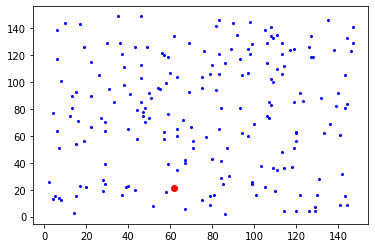

In [172]:
plt.plot(xc[0], yc[0], c='r', marker='o')
plt.scatter(xc[1:], yc[1:], c='b',s = 4)
plt.show()

In [173]:
N = [i for i in range(1, n+1)] #set of clients
V = [0] + N #set of clients including depot
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A} #distance between i and j
Q = 2*n #vehicle capacity can satisfy all customer demands. Capacity constraint is not binding anymore
q = {i: rnd.randint(1, 2) for i in N} #every customer has a demand of 1 

In [174]:
from gurobipy import Model, GRB, quicksum

In [175]:
mdl = Model('TSP')

In [176]:
x = mdl.addVars(A, vtype=GRB.BINARY, name = "x") #if edge between i and j is active, it equals to 1, otherwise 0
f = mdl.addVars(A, vtype=GRB.CONTINUOUS, name = "f") #amount of load of a salesman or a vehicle while just leaving cliend i. This variable is needed for subtour elemination.

In [177]:
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A)) #minimize total length of distance covered by salesman

In [178]:
mdl.addConstrs((quicksum(x[i, j] for j in N if (i,j) in A)== 1 for i in [0] ), name = "c0")# this formulation can be equal to
#2,3,4 and etc. In this case problem turns into be multi TSP, I mean mTSP)

{0: <gurobi.Constr *Awaiting Model Update*>}

In [179]:
#Both c1 and c2 constraints force that salesman can visit a customer if and only if once
mdl.addConstrs((quicksum(x[i, j] for j in V if (i,j) in A) == 1 for i in N), name = "c1")
mdl.addConstrs((quicksum(x[i, j] for i in V if (i,j) in A) == 1 for j in N), name = "c2")

#c3 and c4 constraints prevent subtours. Without these contraints, there would be many subtours
mdl.addConstrs(((quicksum(f[j, i] for j in V if (i,j) in A) - 
                quicksum(f[i,j] for j in V if (i,j) in A)) == q[i] for i in N), name = "c3")

mdl.addConstrs(((f[i, j] - x[i, j] * Q) <=0 for i,j in A), name = "c4")

{(0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 23): <gurobi.Constr *Awaiting Model Update*>,
 (0, 26): <gurobi.Constr *Awaiting Model Update*>,
 (0, 34): <gurobi.Constr *Awaiting Model Update*>,
 (0, 35): <gurobi.Constr *Awaiting Model Update*>,
 (0, 49): <gurobi.Constr *Awaiting Model Update*>,
 (0, 54): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57): <gurobi.Constr *Awaiting Model Update*>,
 (0, 67): <gurobi.Constr *Awaiting Model Update*>,
 (0, 85): <gurobi.Constr *Awaiting Model Update*>,
 (0, 91): <gurobi.Constr *Awaiting Model Update*>,
 (0, 99): <gurobi.Constr *Awaiting Model Update*>,
 (0, 103): <gurobi.Constr *Awaiting Model Update*>,
 (0, 105): <gurobi.Constr *Awaiting Model Update*>,
 (0, 115): <gurobi.Constr *Awaiting Model Update*>,
 (0, 118): <gurobi.Constr *Awaiting Model Update*>,
 (0, 119): <gurobi.Constr *Aw

100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 25015.23it/s]

[0, 196, 146, 149, 178, 14, 127, 12, 54, 103, 49, 34, 96, 58, 53, 24, 154, 179, 120, 1, 36, 11, 184, 190, 182, 27, 22, 95, 138, 52, 194, 156, 33, 159, 160, 20, 63, 84, 144, 85, 143, 57, 132, 23, 3, 7, 91, 193, 67, 26, 181, 199, 197, 173, 168, 62, 77, 40, 113, 130, 161, 59, 187, 79, 13, 38, 106, 70, 90, 18, 51, 6, 64, 145, 68, 21, 101, 8, 42, 169, 195, 167, 115, 137, 125, 105, 164, 140, 50, 71, 157, 47, 155, 32, 25, 73, 39, 107, 2, 119, 118, 163, 124, 99, 172, 35, 170, 158, 126, 97, 171, 122, 150, 200, 175, 37, 93, 162, 56, 41, 81, 76, 165, 104, 19, 188, 129, 65, 110, 60, 148, 180, 152, 31, 100, 147, 189, 98, 131, 9, 176, 198, 17, 123, 69, 15, 191, 44, 174, 82, 151, 72, 92, 48, 141, 89, 75, 111, 83, 133, 192, 5, 80, 87, 136, 30, 45, 88, 135, 108, 55, 117, 142, 4, 16, 128, 186, 66, 46, 61, 183, 10, 109, 94, 29, 112, 134, 43, 121, 177, 116, 28, 185, 74, 86, 139, 166, 102, 78, 114, 153]
Total Distance:  2181.47


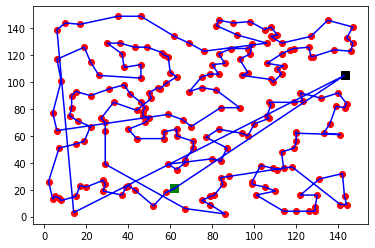

In [199]:
#"go-to closest point everytime" greedy heuristic. Compare solutions produced via this greedy algorithm and mathematicial opt.
#You can use this solution as a warm start to feed mathematicial optimization.
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import time

uzaklık_matrisi = []
for i in range(n+1):
    liste = []
    for j in range(n+1):
        a = ((koordinat[i,0]-koordinat[j,0])**2+(koordinat[i,1]-koordinat[j,1])**2)**0.5
        liste.append(a)
    uzaklık_matrisi.append(liste)
    
plt.scatter(koordinat[:,0:1],koordinat[:,1:2], color = "red")

for i in range(n+1):
    uzaklık_matrisi[i][i] = 1000
           
    
for k in range(n+1):
    for j in range(n+1):
        uzaklık_matrisi[j][k] = uzaklık_matrisi[k][j]
        
uzaklık_matrisi = np.array(uzaklık_matrisi)
en_küçük_indis = 0
sıralama = []
yeni_koordinat = []
yeni_koordinat_x = []
yeni_koordinat_y = []
mesafe = []

for z in tqdm(range(n)):
     
    if z == 0:
        uzaklık_matrisi_revize = uzaklık_matrisi.copy()
        en_küçük_indis = np.argmin(uzaklık_matrisi_revize[0:1,0:n+1])
        a = en_küçük_indis // (n+1)
        b = en_küçük_indis % (n+1)
        sıralama.append(a)
        sıralama.append(b)
        mesafe.append(uzaklık_matrisi[a][b])
       

        uzaklık_matrisi_revize [:,a:a+1] = 1000
        uzaklık_matrisi_revize [:,b:b+1] = 1000
        yeni_koordinat_x.append(koordinat[a][0])
        yeni_koordinat_y.append(koordinat[a][1])
        yeni_koordinat_x.append(koordinat[b][0])
        yeni_koordinat_y.append(koordinat[b][1])

        plt.scatter(yeni_koordinat_x[0],yeni_koordinat_y[0], color = "green", s = 60, marker = "s")
        plt.plot(yeni_koordinat_x,yeni_koordinat_y, color = "blue")
        
        
        
    else:
        mesafe.append(uzaklık_matrisi[np.argmin(uzaklık_matrisi_revize[b])][b])
        b = np.argmin(uzaklık_matrisi_revize[b])
        uzaklık_matrisi_revize [:,b:b+1] = 1000
        sıralama.append(b)
        #time.sleep(0.5)
        yeni_koordinat_x.append(koordinat[b][0])
        yeni_koordinat_y.append(koordinat[b][1])
        
         
mesafe.append(uzaklık_matrisi[sıralama[-1]][sıralama[0]])        
plt.scatter(yeni_koordinat_x[-1],yeni_koordinat_y[-1], color = "black", s = 60, marker = "s")
yeni_koordinat_x.append(koordinat[0][0])
yeni_koordinat_y.append(koordinat[0][1])
plt.plot(yeni_koordinat_x,yeni_koordinat_y, color = "blue")
print(sıralama)
print("Total Distance: ", round(sum(mesafe),2))

In [181]:
mdl.Params.BranchDir = -1
mdl.Params.MipGap = 0.02 
mdl.params.MIPFocus = 1
mdl.params.FlowCoverCuts = 1
mdl.params.ZeroHalfCuts = 1
mdl.optimize()

Changed value of parameter BranchDir to -1
   Prev: 0  Min: -1  Max: 1  Default: 0
Changed value of parameter MipGap to 0.02
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPFocus to 1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter FlowCoverCuts to 1
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ZeroHalfCuts to 1
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9815 rows, 18428 columns and 55161 nonzeros
Model fingerprint: 0xb5ba4b7a
Variable types: 9214 continuous, 9214 integer (9214 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 41 rows and 41 columns
Presolve time: 0.13s
Presolved: 9774 rows, 18387 columns, 55079 nonzeros
Variabl

In [182]:
obj = mdl.getObjective()
#print(obj.getValue())
print("We have better solution than greedy heuristic. Greedy heuristic :",round(sum(mesafe),2),"km, Math Optimization:", round(obj.getValue(),2),"km")

We have better solution than greedy heuristic. Greedy heuristic : 2181.47 km, Math Optimization: 1602.09 km


In [183]:
active_arcs = [a for a in A if x[a].x > 0.99]

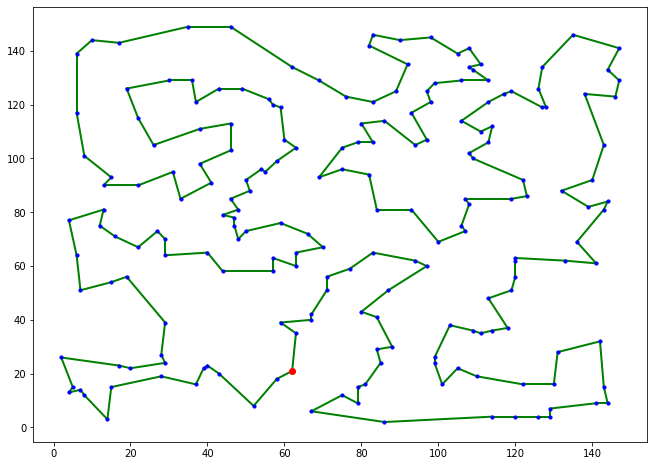

In [184]:
plt.figure(figsize=(11,8))
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0,linewidth = 2)
plt.plot(xc[0], yc[0], c='r', marker='o')
plt.scatter(xc[1:], yc[1:], c='b',s=10)
plt.show()

In [133]:
mdl1 = Model('mTSP')

In [134]:
x1 = mdl1.addVars(A, vtype=GRB.BINARY, name = "x") #if edge between i and j is active, it equals to 1, otherwise 0
f1 = mdl1.addVars(A, vtype=GRB.CONTINUOUS, name = "f") #amount of load of a salesman or a vehicle while just leaving client j. This variable is needed for subtour elemination.

In [135]:
mdl1.setObjective(quicksum(x1[i, j]*c[i, j] for i, j in A)) 

In [136]:
mdl1.addConstrs((quicksum(x1[i, j] for j in N if (i,j) in A)== 2 for i in [0] ), name = "c01") #I have two salesmen

{0: <gurobi.Constr *Awaiting Model Update*>}

In [137]:

mdl1.addConstrs((quicksum(x1[i, j] for j in V if (i,j) in A) == 1 for i in N), name = "c10")
mdl1.addConstrs((quicksum(x1[i, j] for i in V if (i,j) in A) == 1 for j in N), name = "c20")


mdl1.addConstrs(((quicksum(f1[j, i] for j in V if (i,j) in A) - 
                quicksum(f1[i,j] for j in V if (i,j) in A)) == q[i] for i in N), name = "c30")

mdl1.addConstrs(((f1[i, j] - x1[i, j] * Q) <=0 for i,j in A), name = "c40")

{(0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 23): <gurobi.Constr *Awaiting Model Update*>,
 (0, 26): <gurobi.Constr *Awaiting Model Update*>,
 (0, 34): <gurobi.Constr *Awaiting Model Update*>,
 (0, 35): <gurobi.Constr *Awaiting Model Update*>,
 (0, 49): <gurobi.Constr *Awaiting Model Update*>,
 (0, 54): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57): <gurobi.Constr *Awaiting Model Update*>,
 (0, 67): <gurobi.Constr *Awaiting Model Update*>,
 (0, 85): <gurobi.Constr *Awaiting Model Update*>,
 (0, 91): <gurobi.Constr *Awaiting Model Update*>,
 (0, 99): <gurobi.Constr *Awaiting Model Update*>,
 (0, 103): <gurobi.Constr *Awaiting Model Update*>,
 (0, 105): <gurobi.Constr *Awaiting Model Update*>,
 (0, 115): <gurobi.Constr *Awaiting Model Update*>,
 (0, 118): <gurobi.Constr *Awaiting Model Update*>,
 (0, 119): <gurobi.Constr *Aw

In [138]:
mdl1.addConstrs(f1[i,j]<=(n/2) for i,j in A) #a salesman can visit at most n/2 customers. You can deactivate this constraint
#The reverse is not true. I mean,you can not define that a salesman can visit at least 10  customers. This is not possible 
#in this formulation. You can try different formulations for this porpuse.

{(0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 23): <gurobi.Constr *Awaiting Model Update*>,
 (0, 26): <gurobi.Constr *Awaiting Model Update*>,
 (0, 34): <gurobi.Constr *Awaiting Model Update*>,
 (0, 35): <gurobi.Constr *Awaiting Model Update*>,
 (0, 49): <gurobi.Constr *Awaiting Model Update*>,
 (0, 54): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57): <gurobi.Constr *Awaiting Model Update*>,
 (0, 67): <gurobi.Constr *Awaiting Model Update*>,
 (0, 85): <gurobi.Constr *Awaiting Model Update*>,
 (0, 91): <gurobi.Constr *Awaiting Model Update*>,
 (0, 99): <gurobi.Constr *Awaiting Model Update*>,
 (0, 103): <gurobi.Constr *Awaiting Model Update*>,
 (0, 105): <gurobi.Constr *Awaiting Model Update*>,
 (0, 115): <gurobi.Constr *Awaiting Model Update*>,
 (0, 118): <gurobi.Constr *Awaiting Model Update*>,
 (0, 119): <gurobi.Constr *Aw

In [139]:
mdl1.Params.BranchDir = -1
mdl1.Params.MipGap = 0.02 
mdl1.params.MIPFocus = 1
mdl1.params.FlowCoverCuts = 1
mdl1.params.ZeroHalfCuts = 1
mdl1.optimize()

Changed value of parameter BranchDir to -1
   Prev: 0  Min: -1  Max: 1  Default: 0
Changed value of parameter MipGap to 0.02
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPFocus to 1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter FlowCoverCuts to 1
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ZeroHalfCuts to 1
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19029 rows, 18428 columns and 64375 nonzeros
Model fingerprint: 0xb0268c0a
Variable types: 9214 continuous, 9214 integer (9214 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 9255 rows and 41 columns
Presolve time: 0.13s
Presolved: 9774 rows, 18387 columns, 55079 nonzeros
Vari

  1103   933 1620.91968   51  477 1659.98983 1616.15681  2.64%   761  365s
  1108   937 1618.50803   23  463 1659.98983 1617.33806  2.57%   757  370s
  1109   937 1631.95477   57  463 1659.98983 1619.42314  2.44%   757  384s
H 1110   894                    1634.1203663 1619.42314  0.90%   829  394s

Cutting planes:
  Gomory: 2
  Implied bound: 93
  Clique: 1
  MIR: 61
  Flow cover: 268
  Flow path: 13
  GUB cover: 1
  Zero half: 17
  Network: 51
  RLT: 1
  Relax-and-lift: 44

Explored 1112 nodes (994216 simplex iterations) in 394.74 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 1634.12 1659.99 1667.44 ... 1675.1

Optimal solution found (tolerance 2.00e-02)
Best objective 1.634120366297e+03, best bound 1.619423140051e+03, gap 0.8994%


In [189]:
active_arcs1 = [a for a in A if x1[a].x > 0.99]

In [190]:
liste3 = [active_arcs1[0]]
j = 0
while j  <= len(active_arcs1)-1:
    if liste3[-1][1] == active_arcs1[j][0]:
        if active_arcs1[j] not in liste3:
            liste3.append(active_arcs1[j])
            j = -1
    j += 1
    if j == len(active_arcs1):
        break

In [191]:
colors= ["red","green","chocolate","orange","grey","black","purple","blue","magenta","cyan","pink","darkseagreen","yellow"
       ,"lightsalmon","aqua","coral","darkred","azure","limegreen","bisque"]

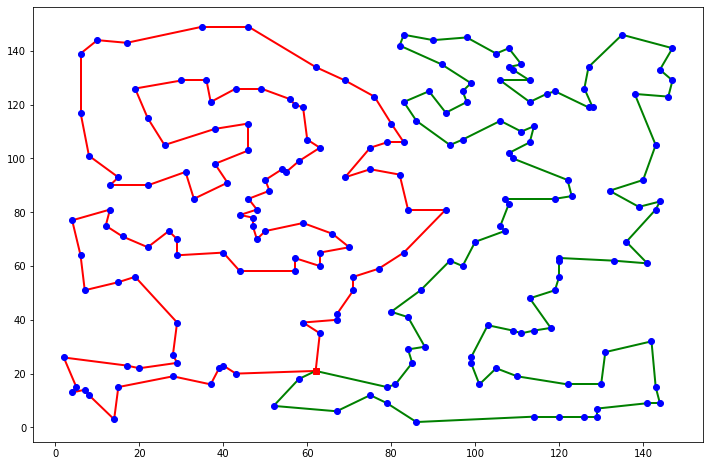

In [197]:
plt.figure(figsize=(12,8))
s = -1
for i, j in liste3:
    if i == 0:
        s += 1 
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=colors[s], zorder=0,linewidth = 2)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
plt.show()